In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import xgboost as xgb
import seaborn as sns
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

## Read CSV
data_source = "../data/vehicle_data/final_bat_auction_data.csv"
df = pd.read_csv(data_source)

print(f'Data ingested -- Found {len(df)} Rows')

/Users/andyczeropski/opt/miniconda3/envs/bat/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Data ingested -- Found 53343 Rows


In [2]:
df.drop(["Mileage Notes", "Details"], inplace=True, axis=1)
print(df.head())

    Make    Model  Year    Miles  Final Bid Price   color  auction_year  \
0  acura  integra  1997  52000.0          26500.0   green          2022   
1  acura  integra  1995  72000.0           7100.0   black          2022   
2  acura  integra  1995  43000.0           8900.0   white          2022   
3  acura  integra  1994  47000.0          11800.0   white          2022   
4  acura  integra  2000  35000.0          15500.0  silver          2022   

   engine_size  cylinders  
0          1.8        4.0  
1          1.8        4.0  
2          1.8        4.0  
3          1.8        4.0  
4          1.8        4.0  


In [3]:
# rename columns to lowercase for easability
df.columns = ['make', 'model', 'year', 'miles', 'final bid price', 'color',
              'auction_year', 'engine_size', 'cylinders']

# Drop any leftover nans
df = df.dropna()
print("Number of unique Makes:", df.make.nunique())

# Check nan values again
print('\nAfter:\n', df.isna().sum())

target_feature = "final bid price"

y = df[target_feature]
X = df.drop(target_feature, axis=1)
# X.head()

Number of unique Makes: 74

After:
 make               0
model              0
year               0
miles              0
final bid price    0
color              0
auction_year       0
engine_size        0
cylinders          0
dtype: int64


(53343, 9)


<AxesSubplot:>

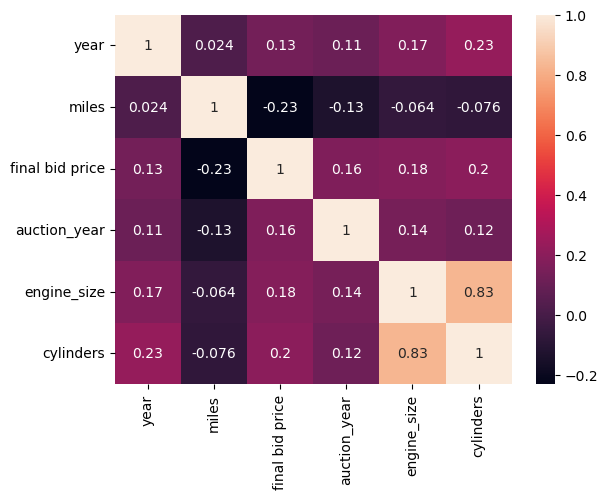

In [4]:
# sns.set(rc={"figure.figsize":(9, 9)})
print(df.shape)
sns.heatmap(df.corr(), annot = True)

In [5]:
## Find Numerical & Categorical Columns
# Get numerical and categorical feature columns
print('\nCalculating Numerical and Categorical Features...')
print(f'There are {len(X.columns)} total columns.')

numerical_features = X.select_dtypes(include='number').columns.tolist()
print(f'There are {len(numerical_features)} numerical features.')

categorical_features = X.select_dtypes(exclude='number').columns.tolist()
print(f'There are {len(categorical_features)} categorical features.', '\n')

print(X.columns)

## Pre-Process Data

print('Fetching Preprocessing Pipeline...\n')

numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean', missing_values=np.nan)),
    ('scale', MinMaxScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

# model = XGBRegressor(n_estimators=100, random_state=42)
model = XGBRegressor(random_state=42, learning_rate=0.5, n_estimators=400, max_depth=5)

params = {
    "learning_rate": 0.01,
    "max_depth": 3
}

# training, we set the early stopping rounds parameter
# model = xgb.train(params, 
#           train, evals=[(train, "train"), (test, "validation")], 
#           num_boost_round=100, early_stopping_rounds=20)


model_pipeline = Pipeline(steps=[
        ('preprocessor', full_processor),
        ('model', model)
    ])

# fit_params = {"model__evals": [(X_train, "train"), (X_valid, "validation")], 
#               "model__params": params}

# model.set_params(**fit_params)


Calculating Numerical and Categorical Features...
There are 8 total columns.
There are 5 numerical features.
There are 3 categorical features. 

Index(['make', 'model', 'year', 'miles', 'color', 'auction_year',
       'engine_size', 'cylinders'],
      dtype='object')
Fetching Preprocessing Pipeline...



## Start Grid Search

In [6]:
# # param_dict = {
# #     'model__learning_rate': [0.01, 0.001, 0.5],
# #     'model__max_depth': [2, 5, 10],
# #     'model__n_estimators': [100, 200, 400]
# # }

# param_dict = {
#     'model__learning_rate': [0.35, 0.45],
#     'model__max_depth': [5],
#     'model__n_estimators': [100, 400]
# }

# print('Starting Grid Search...\n')
# search = GridSearchCV(model_pipeline, param_dict, 
#                   cv=5, 
#                   scoring='neg_mean_absolute_error',
#                   verbose=4)

# search.fit(X_train, y_train)

# print('Best score:', abs(search.best_score_))

# print('Best params:', search.best_params_)

# # print('Best estimator:', search.best_estimator_)

# best_params = search.best_params_.values()

In [7]:
print(len(X_train), len(y_train))

42674 42674


In [8]:
model = XGBRegressor(random_state=42, learning_rate=0.5, n_estimators=400, max_depth=5)

model_pipeline = Pipeline(steps=[
        ('preprocessor', full_processor),
        ('model', model)
    ])

hist = model_pipeline.fit(X_train, y_train)

In [95]:
# Preprocessing of validation data, get predictions
preds = model_pipeline.predict(X_valid)

# Evaluate the model
print('MAE:', mean_absolute_error(y_valid, preds))
preds

MAE: 12128.22420625028


array([ 97396.43 ,  11553.509, 133357.94 , ...,  12656.511,  45706.465,
        61826.44 ], dtype=float32)

In [22]:
model_sigma = dict()
models = list(df.model.unique())
model_train = list(X_train.model.unique())
# missingModels = df[df.model not in X_train.model.unique
[x for x in models if x not in model_train]

['defender l663', 'c110 skyline', '911 safari']

In [96]:
# hist.get_booster().get_score(importance_type='gain')
# hist.named_steps['model'].get_booster().get_score(importance_type='weight')

## Testing Predictions

In [97]:
model_pipeline
model_pipeline.named_steps['preprocessor']

ColumnTransformer(transformers=[('number',
                                 Pipeline(steps=[('impute', SimpleImputer()),
                                                 ('scale', MinMaxScaler())]),
                                 ['year', 'miles', 'auction_year',
                                  'engine_size', 'cylinders']),
                                ('category',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('one-hot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['make', 'model', 'color'])])

In [98]:
MAE = mean_absolute_error(y_valid, preds)
r2 = model_pipeline.score(X_valid, y_valid)

print('MAE:', MAE)
print('R2:', r2)

MAE: 12128.22420625028
R2: 0.7021340694160463


In [99]:
# Custom Predictions
tst_data = ["subaru", "wrx sti", 2020, 55000, "blue", 2022, 2.5, 4]
columns = ['make', 'model', "year", 'miles', 'color', 'auction_year', 'engine_size', 'cylinders']
tst = pd.DataFrame()
for idx, col in enumerate(columns):
    tst[col] = pd.Series(tst_data[idx])
preds = model_pipeline.predict(tst)
preds

array([68306.66], dtype=float32)

## Save Model

In [102]:
import joblib


# Save the XGB model first:
model_pipeline.named_steps['model'].save_model('../api/models/xgb_model.h5')
# Save the preprocessor next
joblib.dump(model_pipeline.named_steps['preprocessor'], '../api/models/preprocessor.joblib')


# # This hack allows us to save the sklearn pipeline:
# model_pipeline.named_steps['model'] = None

# # Finally, save the pipeline:
# joblib.dump(model_pipeline, './models/sklearn_pipeline.joblib')

# del model_pipeline

['../api/models/preprocessor.joblib']